In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd

## Import Files From Simulation:

In [2]:
file = "C:\\users/Thomas/wlcsim_membrane/data/2.10.21_NoInteractions_2hrs_r11v0.txt"
data = np.loadtxt(file) #D:\\myfiles\welcome.txt


## Our Approach to Calculating Percolation Paths Through a Polymer Membrane:

### Defining The System:

In our system we have random copolymers with solvent molecules. Polymers are represented by beads of types 1 and 2 and solvent molecules are individual beads of type 0. No bead can overlap another. 

### Defining Percolation:

A percolation is a pathway through the polymer network that solvent molecules can move through. To form a percolation a solvent molecule will need to have at least one other solvent molecule adjacent to it within some path radius $r$

### What are we trying to learn from the system:

The goal in developing this code is to determine quantitatively the amount of percolation in a membrane. 

### Models for Percolation:
**1. Fire Spread Model:** In this model we measure the percolation paths by tracing the spots where the solvent molecules continue to be adjacent to the previous... It's easier to explain with a picture

## What we need to calculate:

Starting with the final equilibrium state we have x,y,z postion of a bead and it's identity (and also methylation state). We want to calculate percolation paths which will be represented by root mean square. 

#### What Percolation Model do we want to use:

1. Fire spead model:

Proceedure:
1. Pick a bead type
2. pick a random bead of that bead type
3. Check surround bead types to see if they are the same
    a. Pick a radius to search in


# Note: for some reason if you declare two different PolymerNetworks, they can interfere w/ each other (change values)

In [3]:
def generate_test_data(length=10,width=10,height=10,datapoints=500):
    X = np.random.random(datapoints)*length
    Y = np.random.random(datapoints)*width
    Z = np.random.random(datapoints)*height
    Beads = np.random.randint(3,size=(datapoints)).astype('uint8')
    Beads
    return X,Y,Z,Beads

#generate_test_data()

In [4]:
class Bead:
    '''
    '''
    def __init__(self, x, y, z, bead_type):
        self.x = x
        self.y = y
        self.z = z
        self.bead_type = bead_type
        


In [5]:
class Polymer:
    '''
    '''
    
    def __init__(self, bead_list):
        self.bead_list = bead_list
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
   

In [6]:
class PolymerNetwork:
    """
    This represents the postions of bead and their type (time invariant)
    
    Parameters
    ----------
    X : float [array] X 
    """
    
    def __init__(self,X,Y,Z, Beads, beads_per_polymer=40, bead_list=[], polymer_list=[]):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.Beads = Beads
        self.beads_per_polymer = beads_per_polymer
        self.bead_list = bead_list
        self.polymer_list = polymer_list
        
        self.density = Beads.shape[0]/((max(X)-min(X)) * (max(Y)-min(Y)) * (max(Z)-min(Z)))
        
    def visualize(self):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(self.X[Beads==0], self.Y[Beads==0], self.Z[Beads==0],color='y')
        ax.scatter3D(self.X[Beads==1], self.Y[Beads==1], self.Z[Beads==1],color='r')
        ax.scatter3D(self.X[Beads==2], self.Y[Beads==2], self.Z[Beads==2],color='b')
        
    def nearest_neighbor(self,bead_num,radius):
        '''
        Find the average number of beads that surround a bead of the same type within the radius specified
        '''
        X_bead = self.X[Beads==bead_num]
        Y_bead = self.Y[Beads==bead_num]
        Z_bead = self.Z[Beads==bead_num]
        
        total_neighbors = 0
        for i in range(Beads[Beads==bead_num].shape[0]):
            point = np.array([X_bead[i],Y_bead[i],Z_bead[i]])
            displacement = np.sqrt((X_bead - point[0])**2 + (Y_bead - point[1])**2 + (Z_bead - point[2])**2)
            num_neighbor_points = displacement[displacement<=radius].shape[0] -1
            
            total_neighbors += num_neighbor_points

        return total_neighbors/(i+1)
    
    def create_beads(self):
        if len(self.bead_list) != 0:
            raise Exception("bead list already populated")
        for i in range(len(self.X)):
            bead = Bead(self.X[i], self.Y[i], self.Z[i], self.Beads[i])
            self.bead_list.append(bead)
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
    
    def create_polymers(self):
        if len(self.polymer_list) != 0:
            raise Exception("polymer list already populated")
        if len(self.bead_list) == 0:
            raise Exception("Need to run create_beads before create_polymers")
        for i in range(self.beads_per_polymer, len(self.bead_list) + 1, self.beads_per_polymer):
            polymer = Polymer(self.bead_list[i - self.beads_per_polymer : i])
            self.polymer_list.append(polymer)
        
    def print_polymer_list(self, verbose=False):
        for i, poly in enumerate(self.polymer_list):
            print("POLYMER " + str(i))
            if verbose:
                poly.print_bead_list()

In [11]:
'''
Determine the mean square interbead distance
Input: PolymerNetwork
Return: A DataFrame where the columns are a specific polymer in the network, rows are the number of "jumps" n,
        and the values are the average distance squared bewteen beads n jumps away (averaged over all different jumps 
        of size n possible in the polymer)
mean square distance b/w beads
'''
def r2(polymer_network):
    if len(polymer_network.bead_list) == 0:
        raise Exception("Need to run create_beads")
    if len(polymer_network.polymer_list) == 0:
        raise Exception("Need to run create_polymers")
    num_poly = len(polymer_network.polymer_list)
    avg_n_jumps = pd.DataFrame(index=range(polymer_network.beads_per_polymer), columns=range(num_poly))
    
    for i, poly in enumerate(polymer_network.polymer_list):
        # creating matrix of (inter-bead distances)^2 for a given polymer
        num_beads = len(poly.bead_list)
        bead_dist = np.zeros((num_beads, num_beads))    
        for j, bead1 in enumerate(poly.bead_list):
            for k, bead2 in enumerate(poly.bead_list):
                position1 = np.array([bead1.x, bead1.y, bead1.z])
                position2 = np.array([bead2.x, bead2.y, bead2.z])
                displacement_squared = np.sum((position2 - position1)**2)
                bead_dist[j][k] = displacement_squared
        
        # get diagonals, store in the dataframe
        n_jump_dist_avg = np.zeros(num_beads)
        for d in range(num_beads):
            diag = np.diag(bead_dist, d)
            n_jump_dist_avg[d] = np.average(diag)    # populated with average displacements of d jumps
        
        avg_n_jumps[i] = n_jump_dist_avg
        if (i % 500 == 0):
            print("processed polymer " + str(i))

    return avg_n_jumps # dataframe that matches each polymer with the average distance between beads n posiitons away
    

In [7]:
#TEST DATA:

#X,Y,Z,Beads = generate_test_data()
#PNet_Test = PolymerNetwork(X,Y,Z,Beads, beads_per_polymer = 10)
#PNet_Test.create_beads()
#PNet_Test.create_polymers()
#PNet_Test.density

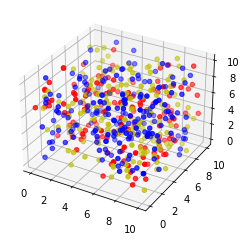

In [8]:
#PNet_Test.visualize()

In [9]:
#PNet_Test.nearest_neighbor(bead_num=0,radius=0.4)

In [10]:
#radii = np.linspace(0,15,100)
#for r in radii:
#    plt.plot(r,PNet_Test.nearest_neighbor(bead_num=0,radius=r),'y.')
#plt.xlabel('Radius')
#plt.ylabel('Average Number of Neighbor Points')

In [12]:
#x = r2(PNet_Test)
#x  # roughly random dist (no polymer chain)

processed polymer 0
processed polymer 15
processed polymer 30
processed polymer 45


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.773463,59.723109,66.703611,67.997025,45.144087,49.316544,64.732925,36.898459,56.552210,57.644626,...,74.805082,43.157218,57.568870,76.039791,27.928917,61.125131,50.480296,70.678922,57.601365,39.742342
2,42.091459,51.365411,77.567632,68.882522,34.462841,36.997620,50.875005,57.530674,44.894592,36.179077,...,78.283089,61.123745,67.343176,49.605496,40.989420,50.982946,61.873498,46.025993,57.087972,36.024234
3,72.382850,42.614733,54.575007,92.236065,30.834154,39.167896,46.370667,41.368017,26.568016,52.314266,...,68.223520,48.180052,61.950039,63.439911,22.203938,48.307591,63.412390,54.399256,48.611375,37.045574
4,68.900164,71.508094,90.999146,65.970226,42.435228,49.842553,62.771392,40.721469,37.314222,43.638446,...,57.573866,58.286998,51.753266,32.122253,22.145380,76.350099,61.785022,55.845095,47.452366,28.516409
5,47.086512,60.352387,66.254526,46.490905,25.570739,41.468258,72.479535,36.907616,48.433122,64.759136,...,69.407891,64.353124,72.029497,76.989357,38.901324,69.222933,38.405195,24.708902,44.407345,48.103630
6,51.329237,65.819448,52.453735,50.341195,37.895883,18.166456,71.120394,13.965074,51.879655,35.706264,...,93.683629,35.286031,60.267212,61.225545,35.324364,40.927140,62.905881,57.506739,41.886319,75.284705
7,52.079288,39.665365,77.254895,30.024710,62.108211,47.865402,70.152667,43.664817,43.454248,44.149193,...,32.372882,34.611832,37.836724,31.495520,16.833492,75.454491,79.071574,36.830208,34.191364,48.839065
8,28.073355,50.007875,97.234105,53.340698,37.777645,39.019178,58.488655,74.075327,60.912053,42.651829,...,84.365598,84.785548,54.558394,85.486053,14.209047,31.381573,89.296870,44.139643,40.558599,47.442774
9,57.777797,33.991031,30.221953,4.429232,49.059121,88.616938,83.617090,77.049683,61.197689,17.135582,...,80.812943,88.817293,87.858580,72.161730,16.921106,73.821272,27.343670,60.571263,13.356179,47.323014


In [15]:
#REAL DATA:

#beads = np.zeros(len(data[:, 0]))   # no chemical identity data
#no_interactions = PolymerNetwork(data[:, 0], data[:, 1], data[:, 2], beads, beads_per_polymer=40)

In [17]:
#no_interactions.create_beads()
#no_interactions.print_bead_list()
#len(no_interactions.bead_list)  # should be 80,000

80000

In [18]:
#no_interactions.create_polymers()
#no_interactions.print_polymer_list(verbose=True)
#print(len(no_interactions.polymer_list)) #should be 2000


2000


In [19]:
#no_interactions.visualize()  #too many beads?

In [20]:
#result = r2(no_interactions)

polymer 0
polymer 1
polymer 2
polymer 3
polymer 4
polymer 5
polymer 6
polymer 7
polymer 8
polymer 9
polymer 10
polymer 11
polymer 12
polymer 13
polymer 14
polymer 15
polymer 16
polymer 17
polymer 18
polymer 19
polymer 20
polymer 21
polymer 22
polymer 23
polymer 24
polymer 25
polymer 26
polymer 27
polymer 28
polymer 29
polymer 30
polymer 31
polymer 32
polymer 33
polymer 34
polymer 35
polymer 36
polymer 37
polymer 38
polymer 39
polymer 40
polymer 41
polymer 42
polymer 43
polymer 44
polymer 45
polymer 46
polymer 47
polymer 48
polymer 49
polymer 50
polymer 51
polymer 52
polymer 53
polymer 54
polymer 55
polymer 56
polymer 57
polymer 58
polymer 59
polymer 60
polymer 61
polymer 62
polymer 63
polymer 64
polymer 65
polymer 66
polymer 67
polymer 68
polymer 69
polymer 70
polymer 71
polymer 72
polymer 73
polymer 74
polymer 75
polymer 76
polymer 77
polymer 78
polymer 79
polymer 80
polymer 81
polymer 82
polymer 83
polymer 84
polymer 85
polymer 86
polymer 87
polymer 88
polymer 89
polymer 90
polymer 9

polymer 694
polymer 695
polymer 696
polymer 697
polymer 698
polymer 699
polymer 700
polymer 701
polymer 702
polymer 703
polymer 704
polymer 705
polymer 706
polymer 707
polymer 708
polymer 709
polymer 710
polymer 711
polymer 712
polymer 713
polymer 714
polymer 715
polymer 716
polymer 717
polymer 718
polymer 719
polymer 720
polymer 721
polymer 722
polymer 723
polymer 724
polymer 725
polymer 726
polymer 727
polymer 728
polymer 729
polymer 730
polymer 731
polymer 732
polymer 733
polymer 734
polymer 735
polymer 736
polymer 737
polymer 738
polymer 739
polymer 740
polymer 741
polymer 742
polymer 743
polymer 744
polymer 745
polymer 746
polymer 747
polymer 748
polymer 749
polymer 750
polymer 751
polymer 752
polymer 753
polymer 754
polymer 755
polymer 756
polymer 757
polymer 758
polymer 759
polymer 760
polymer 761
polymer 762
polymer 763
polymer 764
polymer 765
polymer 766
polymer 767
polymer 768
polymer 769
polymer 770
polymer 771
polymer 772
polymer 773
polymer 774
polymer 775
polymer 776
poly

polymer 1350
polymer 1351
polymer 1352
polymer 1353
polymer 1354
polymer 1355
polymer 1356
polymer 1357
polymer 1358
polymer 1359
polymer 1360
polymer 1361
polymer 1362
polymer 1363
polymer 1364
polymer 1365
polymer 1366
polymer 1367
polymer 1368
polymer 1369
polymer 1370
polymer 1371
polymer 1372
polymer 1373
polymer 1374
polymer 1375
polymer 1376
polymer 1377
polymer 1378
polymer 1379
polymer 1380
polymer 1381
polymer 1382
polymer 1383
polymer 1384
polymer 1385
polymer 1386
polymer 1387
polymer 1388
polymer 1389
polymer 1390
polymer 1391
polymer 1392
polymer 1393
polymer 1394
polymer 1395
polymer 1396
polymer 1397
polymer 1398
polymer 1399
polymer 1400
polymer 1401
polymer 1402
polymer 1403
polymer 1404
polymer 1405
polymer 1406
polymer 1407
polymer 1408
polymer 1409
polymer 1410
polymer 1411
polymer 1412
polymer 1413
polymer 1414
polymer 1415
polymer 1416
polymer 1417
polymer 1418
polymer 1419
polymer 1420
polymer 1421
polymer 1422
polymer 1423
polymer 1424
polymer 1425
polymer 1426

polymer 1984
polymer 1985
polymer 1986
polymer 1987
polymer 1988
polymer 1989
polymer 1990
polymer 1991
polymer 1992
polymer 1993
polymer 1994
polymer 1995
polymer 1996
polymer 1997
polymer 1998
polymer 1999


In [21]:
#result 

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.157959,0.147473,0.162123,0.171162,0.162561,0.162067,0.161183,0.154522,0.170941,0.160492,...,0.151643,0.160275,0.164059,0.162455,0.164502,0.158164,0.166980,0.166170,0.167712,0.165205
2,0.573377,0.539237,0.587038,0.622909,0.604836,0.601517,0.589440,0.558778,0.624934,0.583882,...,0.566049,0.594855,0.596864,0.602460,0.613337,0.579796,0.610138,0.605794,0.622890,0.598204
3,1.180367,1.127568,1.236802,1.296639,1.284694,1.278670,1.230059,1.142763,1.304900,1.204526,...,1.202132,1.231776,1.252014,1.271281,1.303608,1.220319,1.272031,1.268324,1.298355,1.213309
4,1.932930,1.870145,2.067931,2.125915,2.153205,2.152920,2.036066,1.851368,2.166873,1.977669,...,2.025574,2.021220,2.086195,2.127505,2.213145,2.038322,2.107563,2.116452,2.151094,1.948961
5,2.795613,2.754665,3.036090,3.037963,3.182354,3.192074,2.961980,2.648915,3.158195,2.858728,...,3.027642,2.947989,3.097328,3.140385,3.331576,3.002021,3.080127,3.099901,3.136043,2.767160
6,3.747430,3.762927,4.067861,3.982647,4.356874,4.373395,3.956739,3.500558,4.232817,3.819345,...,4.203597,4.008207,4.247694,4.278919,4.647956,4.075729,4.138215,4.172037,4.214668,3.632603
7,4.737164,4.874618,5.168995,4.875715,5.682241,5.681339,4.971550,4.374073,5.366996,4.843066,...,5.520334,5.151825,5.530251,5.497040,6.154708,5.260663,5.248536,5.304903,5.315878,4.513862
8,5.749693,6.064318,6.332719,5.669219,7.128789,7.025517,5.966913,5.254509,6.554114,5.897886,...,6.955241,6.344597,6.941923,6.770273,7.822760,6.538306,6.360340,6.506445,6.360172,5.367964
9,6.792205,7.344906,7.551715,6.308892,8.653894,8.366124,6.929147,6.109804,7.801467,6.938785,...,8.452390,7.545457,8.443768,8.057853,9.629124,7.892571,7.452251,7.751292,7.360349,6.189421
